# Zillow

## Goal: 
* Find the key drivers of property value for single family properties.
* Construct an ML Regression model that predicts propery tax assessed values of Single Family Properties using attributes of the properties.
* Target = Assessed Worth

## <div class="alert alert-block alert-info"> Imports<div>

In [1]:
# My Modules
import wrangle as wr
import explore as ex
import stats_conclude as sc
import evaluate as ev

# Imports
import os

# Numbers
import pandas as pd 
import numpy as np
import scipy.stats as stats

# Vizzes
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting
from sklearn.model_selection import train_test_split

# Engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

Load in successful, awaiting commands...


## <div class="alert alert-block alert-info"> Wrangle
      
### Acquire
* Data acquired from mySQL Codeup Server using env.py credentials
* It contained 52,442 rows and 7 columns before cleaning/encoding
* Each row represents a single family residential property
* Each column represents a feature of the property
  
### Prepare
* Checked column data types
* Checked for duplicates 
    * 122 duplicates found in parcelid
    * deleted duplicate occurences, kept last value because it makes sense that you can sell a home more than once in one year. The last sell likely has the most recent assessed worth.
* Checked for nulls
    * Sqft: 81
    * Assessed Worth: 1
    * Year: 114
    * AC: 38,705 (76% of AC data is nulls... I will drop, not enough data to interpret)
* Split data into train, validate and test (60/20/20)
    * target = 'assessed worth'
* Outliers have been removed for this iteration of the project
    
### Data Dictionary
* Explanation of dataset features
 

### Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Bed| The number of bedrooms|
|Bath| The number of bathrooms|
|Sqft| The square feet of the property|
|Assessed Worth| **target** This is the assessed worth of the home|
|County| This is the location of the property, (LA, Orange, Venutra)|
|Date| This is the transaction date|

In [2]:
# Acquire
df = wr.get_zillow()

CSV file found and loaded


In [3]:
# Prepare: cleaning data
df_clean = wr.wrangle_zillow(df)

Returning Zillow's Single Family Residential Homes from 2017
--------------------------------------------
Renamed columns for ease of use
NaN's removed: Percent Original Data Remaining: 100.0
Bed datatype changed from float to integer
Changed FIPS code to actual county name
--------------------------------------------
County is a categorical column.
Date is a categorical column.
Bed <= 5.5 and > 1.5
Bath <= 4.5 and > 0.5
Sqft <= 3640.0 and > -160.0
Assessed worth <= 1135281.5 and > -386956.5
Outliers removed: Percent Original Data Remaining: 88.0
DataFrame is clean and ready for exploration :)


In [4]:
# Prepare: SPLIT
train, validate, test = wr.split_zillow(df_clean)

Prepared DF: (45902, 6)
Train: (27540, 6)
Validate: (9181, 6)
Test: (9181, 6)


<div class="alert alert-block alert-info"> 
    
## Explore
    
### Questions To Answer:
1. What is more important for property value, bathrooms or bedrooms?
2. Does sqft affect value?
3. Does having A/C affect property value?
    * During exploration of the data, the AC column had over 38,000 nulls. I couldn't properly impute the data without manipulating the data an egregious amount.
    * The AC column was dropped.
4. Does County affect worth?
   

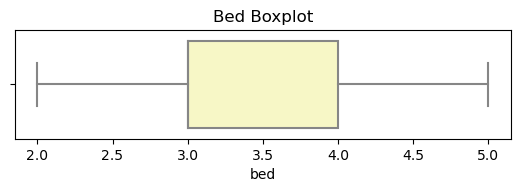

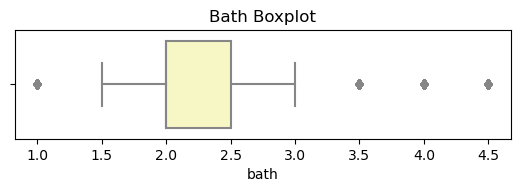

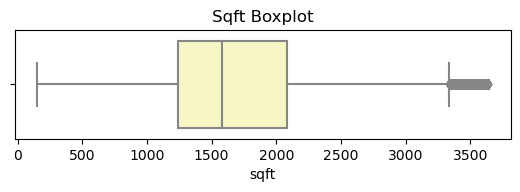

In [5]:
# univariate analysis
ex.visual_explore_univariate(df_clean)

## <div class="alert alert-block alert-info">  1. What is more important for worth: bathrooms or bedrooms?

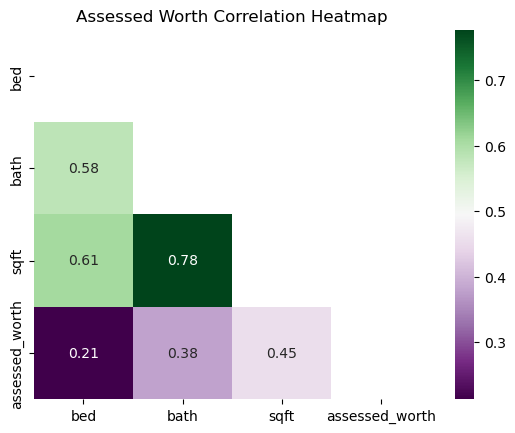

In [6]:
# visualize
ex.plot_heatmap(train)

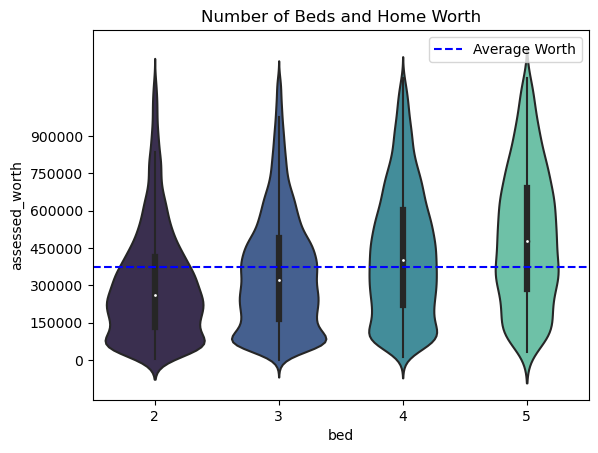

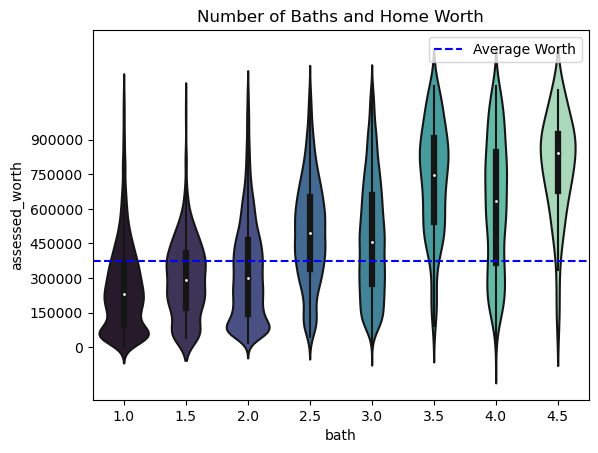

In [7]:
# visualize
ex.plot_bed_bath(train, 'bed', 'bath')

<div class="alert alert-block alert-info"> 

According to the correlation chart, bedrooms doesn't seem to have a great affect on worth. The violinplot further confirms this as the means are linear. 
    
The number of bathrooms does have a significant correlation factor on the worth of a home. The violinplot shows where this likely occurs at jump from a whole bath to a half bath at the 2-2.5, 3-3.5, and 4-4.5 bath ranges.

### Anaylze 

$H_0$: The mean of bedrooms is <= to the $\mu$ of home value

$H_a$: The mean of bedrooms is > to the $\mu$ of home value

In [8]:
# Using one sample, left-tailed t-test with assumptions met
sc.conclude_1samp_lt(train.bed, train.assessed_worth.mean())

Assumptions are met: One-Sample, Left-Tailed T-Test successful...
t-stat: -78406690.18333378 < 0?
p-value: 0.0 < 0.05?

----
We can reject the null hypothesis.


### Anaylze 

$H_0$: The mean of bathrooms is <= to the $\mu$ of home value

$H_a$: The mean of bathrooms is > to the $\mu$ of home value

In [9]:
# Using one sample, left-tailed, t-test with assumptions met
sc.conclude_1samp_lt(train.bath, train.assessed_worth.mean())

Assumptions are met: One-Sample, Left-Tailed T-Test successful...
t-stat: -84007036.75660767 < 0?
p-value: 0.0 < 0.05?

----
We can reject the null hypothesis.


<div class="alert alert-block alert-info">
Bedroom AND bathroom count failed to reject on two tail and right tailed test. Both rejected the null on the left tailed test. 
    
This demonstrates that the cheaper a home is, the more bedrooms and bathrooms play a role in the worth.
    
* Overall, bedroom and bathroom count does not play a signficant role in a homes value.


## 2. Does Sqft affect worth?

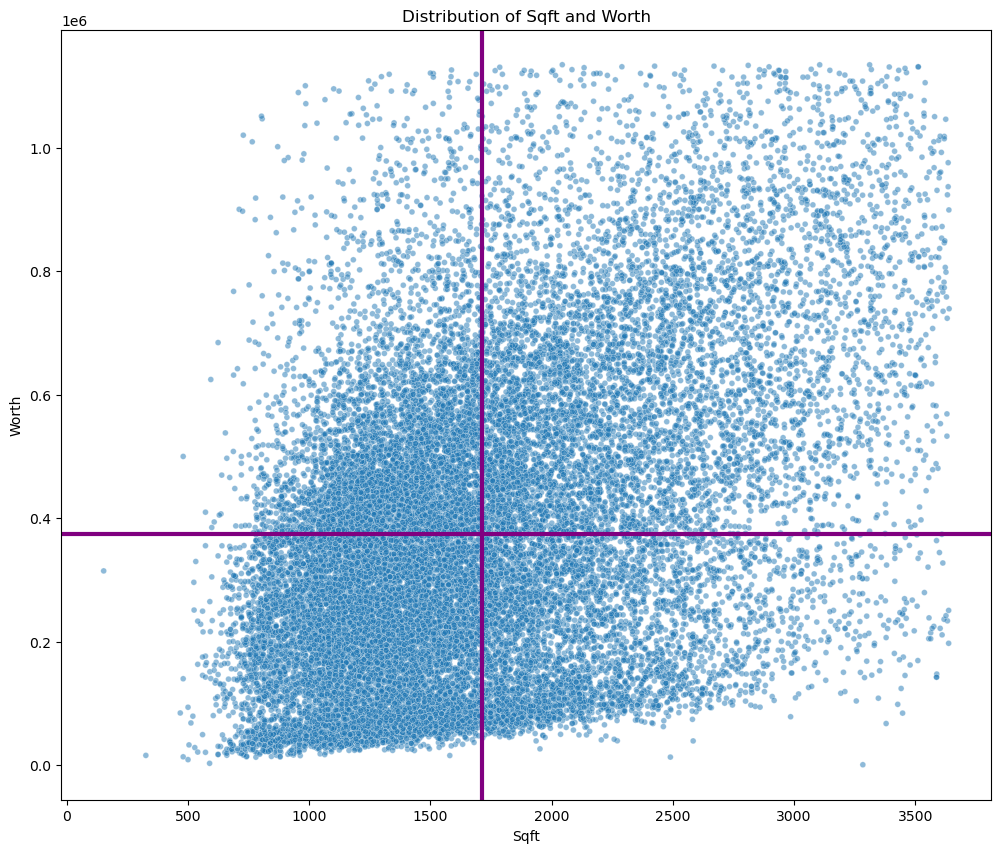

In [10]:
# visualize
ex.plot_sqft(train)

### Anaylze 

$H_0$: The mean of sqft is <= to the $\mu$ of home value

$H_a$: The mean of sqft is > to the $\mu$ of home value

In [11]:
# Using one sample t-test with assumptions met
sc.conclude_1samp_lt(train.sqft, train.assessed_worth.mean())

Assumptions are met: One-Sample, Left-Tailed T-Test successful...
t-stat: -99259.1002832965 < 0?
p-value: 0.0 < 0.05?

----
We can reject the null hypothesis.


<div class="alert alert-block alert-info">
There are two relationships with sqft and worth as displayed in the graph.

* One for higher worth homes that confirms our hypothesis that sqft matters less as the home goes up in worth.
* The second relationship is for lower value homes where sqft matters more below the $150,000 worth mark.
    
---
    
Overall, just like with bed and bath count, sqft rejected the null for the left-tailed test. This matches what we can see visually. The more a home is worth, the less bed, bath, and apparently sqft matter. Vice versa for lower worth homes.

## 3. Does having A/C affect worth?

#### 38,000+ Nulls, dropped the column, not of value in its current state

## 4. Does County affect worth?

County Count
LA         17892
Orange      7267
Ventura     2381
Name: county, dtype: int64
---
Proportion of Dataset
LA         65.0
Orange     26.0
Ventura     9.0
Name: county, dtype: float64 2
---
Hypothesize
H_0: County does not affect assessed worth
H_a: County affects assessed worth
---
Analyze
p-value = 6.548348113367851e-43 < 0.05
----
We reject the null hypothesis, County does affect assessed worth.


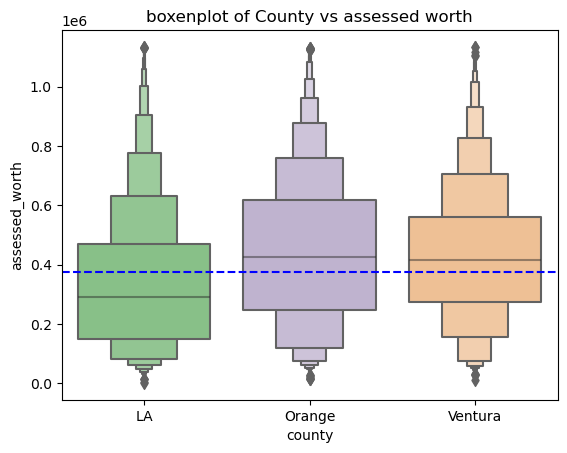

In [12]:
# county with chi^2 test
ex.plot_categorical_vars(train.drop(columns=['date']))

<div class="alert alert-block alert-info">  

County impacts the worth of a home:
    
* The mean worth for LA is far lower than Orange and Ventura county even though it has the highest proportion of values. 
* Ventura, having only 9% of the proportion is almost equal to Orange County mean home worth.
    
---
    
This could be the "something" we are missing for increasing the predictability.

<div class="alert alert-block alert-info">  

### Explore Takeaways:

**Target = Assessed Worth**

There is a feature that is not in this dataset that likely contributes greater to a house's worth. It may have to be engineered from existing features that are correlated.
    
In this first iteration, we will proceed to modeling with the features we have confirmed to be relevant.

* Bed
* Bath
* Sqft
* County
    
It almost feels like real-life with the cheaper the house, the more important bedrooms, bathrooms, and sqft are. While the homes climb in price, these features become less important. Something else is affecting worth...
<div> 

<div class="alert alert-block alert-info"> 

## Preprocessing

* Encode any categoricals

* Engineered Features:
    * None for this iteration
  
* Scale into train, validate, test    
* Split into X_train, y_train, X_validate, y_validate, X_test, y_test


In [13]:
# Encode
df_encoded = ex.encode_zillow(df_clean)

Encoded County column and renamed encoded columns for readability
DataFrame is encoded and ready for modeling. :)


In [14]:
# Split
train_e, validate_e, test_e, = wr.split_zillow(df_encoded)

Prepared DF: (45902, 6)
Train: (27540, 6)
Validate: (9181, 6)
Test: (9181, 6)


In [15]:
# Assign
X_train, y_train, X_validate, y_validate, X_test, y_test = \
wr.x_y_train_validate_test(train_e, validate_e, test_e, 'assessed_worth')

Variable assignment successful...
Verifying number of features and target:
Train: ((27540, 5), (27540, 1))
Validate: ((9181, 5), (9181, 1))
Test: ((9181, 5), (9181, 1))


In [16]:
# Scale
to_scale = X_train.columns.tolist()

X_train_scaled, X_validate_scaled, X_test_scaled = wr.scale_data(X_train, X_validate, X_test, to_scale)

<div class="alert alert-block alert-info"> 
    
## Model
    
### Features to Send In:
    
* Bed
* Bath
* Sqft
* Encoded Counties
    
### Features to Exclude:
  
* Excluded Date because it needs some engineering to make it applicable, next steps...

### Models to Run:
    
* OLS (Linear Regression)
* LassoLars
* GLM (Generalized Linear Model)
* Polynomial Regression (Degree of X)
 
---
    
RMSE and R2 are the evaluation metrics   
    
Focus is to accurately predict property value for this iteration.

In [24]:
# calculating SSE & SSE_baseline values and results of test 
SSE, SSE_baseline, metrics_df = ev.baseline_test(X_train_scaled, y_train, X_test_scaled, y_test)

In [23]:
# compare results to baseline, true if better
ev.better_than_baseline(SSE, SSE_baseline)

True

In [20]:
# visualize
metrics_df

,Model,RMSE,R2
0,Baseline,246078.469289,1.110223e-16
1,POLY_2,215280.877803,2.622933e-01


<div class="alert alert-block alert-info">
    
## Conclusion
    

### Explore:
    
* There is a clear positive relationship with sqft and worth as displayed in the graph.
    
    
* Overall, bed, bath, and sqft rejected the null for the left-tailed test. This matches what we saw visually. The more a home is worth, the less these features seem to matter.
   
* Something else affects the worth in a greater way and it's related to Counties, possibly, a mountain range? ...
    
### Modeling:
    
* Baseline RMSE = $246,079 of error<br>
    
* Poly RMSE = $215,281 of error<br>
    
* Baseline R2 = .111<br>
* Poly R2 = .262<br>
    
### Recommendations:
 
* For the data: Engineer Location Features to improve predicatability of the model
* For the data scientsist: Check for multicollinearity among the predictor variables and remove any highly correlated variables, replacing with new features
* For the business: Improvements in features will increase performance and lead to better results

## Write to CSV to Predict Property Value

In [20]:
# WRITE TO CSV
# ev.to_csv(train, test)